In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMaker import *

In [2]:
IMAGE_SHAPE = (5, 127, 127)
GB_LIMIT = 10

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 1000
LEARNING_RATE = 0.0001
Z_MAX = 4
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'z_max': Z_MAX
}

In [5]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training_{Z_MAX}_small.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation_{Z_MAX}_small.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing_{Z_MAX}_small.hdf5'

In [6]:
column_names = ['object_id', 'specz_redshift', 'g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
with h5py.File(TRAIN_PATH, 'r') as hf:
    train_df = pd.DataFrame()
    for name in column_names:
        train_df[name] = hf[name][:]
    train_images = np.asarray(hf['image'][:])
    
with h5py.File(VAL_PATH, 'r') as hf:
    val_df = pd.DataFrame()
    for name in column_names:
        val_df[name] = hf[name][:]
    val_images = np.asarray(hf['image'][:])
    
with h5py.File(TEST_PATH, 'r') as hf:
    test_df = pd.DataFrame()
    for name in column_names:
        test_df[name] = hf[name][:]
    test_images = np.asarray(hf['image'][:])

In [7]:
mags = ['g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
X_train, X_val, X_test = train_df[mags], val_df[mags], test_df[mags]
y_train, y_val, y_test = train_df['specz_redshift'], val_df['specz_redshift'], test_df['specz_redshift']
OID_train, OID_val, OID_test = train_df['object_id'], val_df['object_id'], test_df['object_id']

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [9]:
# for now, only run the NN architecture
# add callbacks

In [10]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [11]:
input_nn = Input(shape=X_train.shape[1:])
hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_nn)
hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)

input_cnn = Input(shape=(5,127,127))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(input_cnn)
pool1 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv1)
conv2 = Conv2D(64, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv2)
conv3 = Conv2D(128, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first')(pool2)
pool3 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv3)
conv4 = Conv2D(256, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first')(pool3)
pool4 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv4)
conv5 = Conv2D(256, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first')(pool4)
pool5 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv5)
conv6 = Conv2D(512, kernel_size=(3,3),activation='relu', padding='same', data_format='channels_first')(pool5)
conv7 = Conv2D(512, kernel_size=(2,2),activation='relu', padding='same', data_format='channels_first')(conv6)
flatten = Flatten()(conv7)
dense1 = Dense(512, activation='tanh')(flatten)
dense2 = Dense(128, activation='tanh')(dense1)
dense3 = Dense(32, activation='tanh')(dense2)

concat = Concatenate()([hidden4, dense3])
distribution_params = Dense(units=2)(concat)
output = tfp.layers.IndependentNormal(1)(distribution_params)
model = Model(inputs=[input_nn, input_cnn], outputs=[output])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 127, 127) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 127, 127) 1472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 63, 63)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 63, 63)   8256        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [13]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [14]:
model_name = 'HSC_v6_NN_neurips_combined_with_5pool_v3'

checkpoint_filepath = os.path.join('/models/', model_name)+'/'+model_name
log_dir = os.path.join('/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_freq='epoch',
    save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [15]:
model.fit(x=[X_train, train_images], y=y_train, batch_size=hparams['batch_size'], epochs=hparams['num_epochs'], shuffle=True, verbose=1, validation_data=([X_val, val_images], y_val), callbacks=[tensorboard_callback, model_checkpoint_callback, hparam_callback])

Epoch 1/1000
40/40 [==============================] - 414s 94ms/step - loss: 0.3933 - mse: 0.2949 - val_loss: 0.3000 - val_mse: 0.2232
Epoch 2/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.2740 - mse: 0.1936 - val_loss: 0.2580 - val_mse: 0.2029
Epoch 3/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.2356 - mse: 0.1750 - val_loss: 0.2149 - val_mse: 0.1819
Epoch 4/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.1925 - mse: 0.1597 - val_loss: 0.1880 - val_mse: 0.1736
Epoch 5/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.1779 - mse: 0.1553 - val_loss: 0.1860 - val_mse: 0.1688
Epoch 6/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.1733 - mse: 0.1582 - val_loss: 0.1812 - val_mse: 0.1782
Epoch 7/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.1673 - mse: 0.1601 - val_loss: 0.1784 - val_mse: 0.1764
Epoch 8/1000
40/40 [==============================] - 3s 66ms/step 

40/40 [==============================] - 3s 68ms/step - loss: 0.0097 - mse: 0.0153 - val_loss: 0.1279 - val_mse: 0.0702
Epoch 124/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0085 - mse: 0.0150 - val_loss: 0.1294 - val_mse: 0.0718
Epoch 125/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0084 - mse: 0.0149 - val_loss: 0.1282 - val_mse: 0.0710
Epoch 126/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0086 - mse: 0.0147 - val_loss: 0.1311 - val_mse: 0.0697
Epoch 127/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0092 - mse: 0.0149 - val_loss: 0.1324 - val_mse: 0.0752
Epoch 128/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0104 - mse: 0.0147 - val_loss: 0.1313 - val_mse: 0.0700
Epoch 129/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0112 - mse: 0.0148 - val_loss: 0.1296 - val_mse: 0.0721
Epoch 130/1000
40/40 [==============================] - 3s 68ms/step -

Epoch 184/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0045 - mse: 0.0100 - val_loss: 0.1262 - val_mse: 0.0699
Epoch 185/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0041 - mse: 0.0100 - val_loss: 0.1282 - val_mse: 0.0707
Epoch 186/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0042 - mse: 0.0099 - val_loss: 0.1277 - val_mse: 0.0702
Epoch 187/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0041 - mse: 0.0099 - val_loss: 0.1288 - val_mse: 0.0700
Epoch 188/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0064 - mse: 0.0102 - val_loss: 0.1287 - val_mse: 0.0707
Epoch 189/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0050 - mse: 0.0100 - val_loss: 0.1284 - val_mse: 0.0703
Epoch 190/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0047 - mse: 0.0099 - val_loss: 0.1266 - val_mse: 0.0693
Epoch 191/1000
40/40 [==============================] -

Epoch 305/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0049 - mse: 0.0055 - val_loss: 0.1230 - val_mse: 0.0699
Epoch 306/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0035 - mse: 0.0053 - val_loss: 0.1246 - val_mse: 0.0696
Epoch 307/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0033 - mse: 0.0055 - val_loss: 0.1245 - val_mse: 0.0714
Epoch 308/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0033 - mse: 0.0055 - val_loss: 0.1237 - val_mse: 0.0694
Epoch 309/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0027 - mse: 0.0053 - val_loss: 0.1236 - val_mse: 0.0712
Epoch 310/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0026 - mse: 0.0053 - val_loss: 0.1234 - val_mse: 0.0686
Epoch 311/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0025 - mse: 0.0053 - val_loss: 0.1235 - val_mse: 0.0695
Epoch 312/1000
40/40 [==============================] -

Epoch 426/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0014 - mse: 0.0031 - val_loss: 0.1204 - val_mse: 0.0715
Epoch 427/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0012 - mse: 0.0031 - val_loss: 0.1205 - val_mse: 0.0715
Epoch 428/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0014 - mse: 0.0031 - val_loss: 0.1211 - val_mse: 0.0731
Epoch 429/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 0.1207 - val_mse: 0.0709
Epoch 430/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 0.1205 - val_mse: 0.0713
Epoch 431/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0017 - mse: 0.0031 - val_loss: 0.1213 - val_mse: 0.0704
Epoch 432/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0026 - mse: 0.0032 - val_loss: 0.1208 - val_mse: 0.0716
Epoch 433/1000
40/40 [==============================] -

40/40 [==============================] - 3s 68ms/step - loss: 0.0014 - mse: 0.0027 - val_loss: 0.1185 - val_mse: 0.0715
Epoch 547/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0012 - mse: 0.0027 - val_loss: 0.1182 - val_mse: 0.0722
Epoch 548/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0011 - mse: 0.0027 - val_loss: 0.1175 - val_mse: 0.0725
Epoch 549/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0034 - mse: 0.0029 - val_loss: 0.1188 - val_mse: 0.0737
Epoch 550/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0030 - mse: 0.0028 - val_loss: 0.1188 - val_mse: 0.0756
Epoch 551/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0023 - mse: 0.0028 - val_loss: 0.1167 - val_mse: 0.0714
Epoch 552/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.1165 - val_mse: 0.0717
Epoch 553/1000
40/40 [==============================] - 3s 68ms/step -

40/40 [==============================] - 3s 67ms/step - loss: 0.0011 - mse: 0.0024 - val_loss: 0.1190 - val_mse: 0.0781
Epoch 667/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0013 - mse: 0.0025 - val_loss: 0.1157 - val_mse: 0.0740
Epoch 668/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0011 - mse: 0.0025 - val_loss: 0.1161 - val_mse: 0.0741
Epoch 669/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0011 - mse: 0.0024 - val_loss: 0.1169 - val_mse: 0.0746
Epoch 670/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0010 - mse: 0.0024 - val_loss: 0.1148 - val_mse: 0.0721
Epoch 671/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0016 - mse: 0.0025 - val_loss: 0.1158 - val_mse: 0.0741
Epoch 672/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0019 - mse: 0.0025 - val_loss: 0.1165 - val_mse: 0.0749
Epoch 673/1000
40/40 [==============================] - 3s 68ms/step -

Epoch 783/1000
40/40 [==============================] - 3s 68ms/step - loss: 3.0891e-04 - mse: 1.6690e-04 - val_loss: 0.1134 - val_mse: 0.0702
Epoch 784/1000
40/40 [==============================] - 3s 67ms/step - loss: 2.8113e-04 - mse: 1.6161e-04 - val_loss: 0.1136 - val_mse: 0.0703
Epoch 785/1000
40/40 [==============================] - 3s 67ms/step - loss: 2.5519e-04 - mse: 1.5801e-04 - val_loss: 0.1136 - val_mse: 0.0700
Epoch 786/1000
40/40 [==============================] - 3s 67ms/step - loss: 2.3333e-04 - mse: 1.5409e-04 - val_loss: 0.1139 - val_mse: 0.0707
Epoch 787/1000
40/40 [==============================] - 3s 67ms/step - loss: 2.2682e-04 - mse: 1.5288e-04 - val_loss: 0.1136 - val_mse: 0.0703
Epoch 788/1000
40/40 [==============================] - 3s 67ms/step - loss: 2.2565e-04 - mse: 1.5422e-04 - val_loss: 0.1137 - val_mse: 0.0704
Epoch 789/1000
40/40 [==============================] - 3s 68ms/step - loss: 2.3587e-04 - mse: 1.5396e-04 - val_loss: 0.1139 - val_mse: 0.0709

Epoch 898/1000
40/40 [==============================] - 3s 67ms/step - loss: 7.9712e-04 - mse: 2.6740e-04 - val_loss: 0.1150 - val_mse: 0.0746
Epoch 899/1000
40/40 [==============================] - 3s 67ms/step - loss: 9.3894e-04 - mse: 2.9199e-04 - val_loss: 0.1129 - val_mse: 0.0709
Epoch 900/1000
40/40 [==============================] - 3s 67ms/step - loss: 8.5536e-04 - mse: 2.5895e-04 - val_loss: 0.1132 - val_mse: 0.0731
Epoch 901/1000
40/40 [==============================] - 3s 67ms/step - loss: 7.7400e-04 - mse: 2.3345e-04 - val_loss: 0.1135 - val_mse: 0.0723
Epoch 902/1000
40/40 [==============================] - 3s 68ms/step - loss: 7.7122e-04 - mse: 2.2636e-04 - val_loss: 0.1122 - val_mse: 0.0709
Epoch 903/1000
40/40 [==============================] - 3s 68ms/step - loss: 8.6393e-04 - mse: 2.2103e-04 - val_loss: 0.1136 - val_mse: 0.0729
Epoch 904/1000
40/40 [==============================] - 3s 67ms/step - loss: 7.1598e-04 - mse: 2.1002e-04 - val_loss: 0.1143 - val_mse: 0.0740

In [16]:
evaluated_model = model([X_test, test_images])

In [18]:
mean_arr = evaluated_model.mean().numpy()
std_arr = evaluated_model.stddev().numpy()

In [19]:
y_pred = np.ravel(mean_arr) # to make ndim = 1
y_pred

array([0.34856498, 0.28132868, 0.554369  , ..., 0.04013675, 0.64327717,
       0.76343924], dtype=float32)

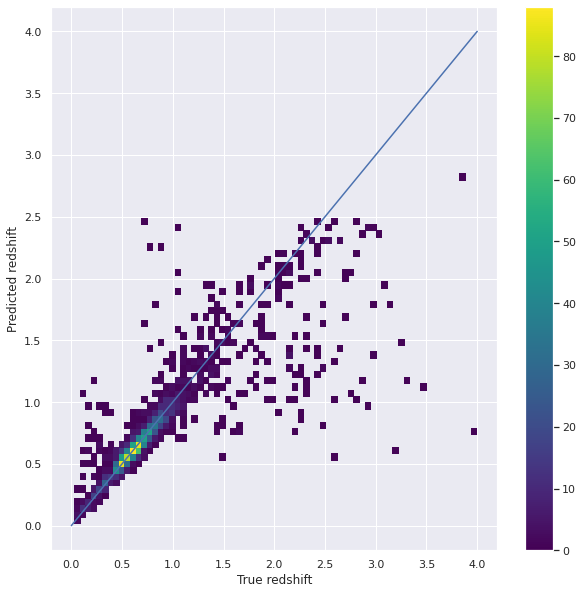

In [20]:
plot_predictions(y_pred, y_test)

In [21]:
metrics = get_point_metrics(pd.Series(y_pred), pd.Series(y_test))

In [22]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.108701,0.000325,0.000137,0.039141,0.03514,0.1385,0.0745,0.074355


In [23]:
df = pd.DataFrame(y_pred, columns=['photoz'])
df['photz_err'] = np.ravel(std_arr)
df['specz'] = y_test
df['object_id'] = OID_test
if os.path.exists(f'/predictions/{model_name}') == False:
    os.makedirs(f'/predictions/{model_name}')
    
df.to_csv(f'/predictions/{model_name}/testing_predictions.csv', index=False)

In [24]:
if os.path.exists(f'predictions/{model_name}') ==  False:
    os.makedirs(f'predictions/{model_name}')
    
metrics.to_csv(f'/predictions/{model_name}/testing_metrics.csv', index=False)

In [25]:
y_train

0       2.17865
1       0.84550
2       0.44850
3       0.37001
4       0.58149
         ...   
9995    0.76330
9996    0.81340
9997    0.64226
9998    0.49758
9999    0.57557
Name: specz_redshift, Length: 10000, dtype: float64

In [26]:
# v1 batch_size = 256
# v2 batch_size = None